<a href="https://colab.research.google.com/github/lherron2/simple-diffusion/blob/main/%20simple-diffusion/simple_diffusion/simple_diffusion_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/lherron2/simple-diffusion
! pip install einops
%cd simple-diffusion/simple_diffusion

Cloning into 'simple-diffusion'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 116 (delta 15), reused 22 (delta 7), pack-reused 77
Receiving objects: 100% (116/116), 335.95 MiB | 18.09 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00
/content/simple-diffusion/simple_diffusion


## Score-Based generative models

Score-based generative models frame inference as a stochastic process. The ideas was originally introduced in [__Deep Unsupervised Learning using Nonequilibrium Thermodynamics__](http://proceedings.mlr.press/v37/sohl-dickstein15.pdf). In this work the authors attempt to generate new samples by inverting a stochastic process. More precisely, the authors define a Markov chain which relaxes to a gaussian stationary distribution for any initial conditions, and they train a neural network to invert the stochastic process.

![swissroll](https://github.com/lherron2/simple-diffusion/blob/main/img/swissroll-diffusion.png?raw=1)

Despite the originality of their work, the approach of using stochastic processes as generative models was ignored for several years.


The second work which uses stochastic processes for inference is [__Generative Modeling by Estimating Gradients of the Data Distribution__](https://proceedings.neurips.cc/paper_files/paper/2019/file/3001ef257407d5a371a96dcd947c7d93-Paper.pdf). In this work the authors make explicit connections between Langevin dynamics and Markov Chain Monte Carlo (MCMC) sampling from a probability distribution, where the potential in Langevin dynamics *is* the probability distribution which is to be sampled from. In particular, sampling from the empirical data distribution amounts to estimating the *score*, which is just the gradient of the log probability, defined as 
$$
\mathbf{s}(\mathbf{x}) = \nabla_\mathbf{x} \log p(\mathbf{x})
$$
Intuitively, the score points towards regions of low-probability density, so moving against the score allows sampling from high-probability regions of the data space. This is analogus to force being defined as $-\nabla_\mathbf{x}V(\mathbf{x})$.

This work also points out the fundamental role that noise plays when sampling from a low-dimensional manifold embedded in a high dimensional ambient space. If one tries to perform MCMC sampling on a low-dimensional manifold in an ambient space, the gradient (score) will point off of the manifold! Noise adds additional structure to the ambient space and prevents the sampling from going off into the void.

The paper whose formalism has gained the most widespread adoption is __[Score-Based Generative Modeling through Stochastic Differential Equations](https://openreview.net/pdf/ef0eadbe07115b0853e964f17aa09d811cd490f1.pdf)__, which makes explicit connections between score-based models, stochastic differntial equations, and Markov Chain approaches. They achieve state of the art in image generation by solving stochastic differential equations (SDEs). In particular, they note that any SDE of the form
$$
\mathrm{d}\mathbf{x} = \mathbf{f}(\mathbf{x}, t)\mathrm{d}t + g(t)\mathrm{d}\mathbf{w}
$$
    corresponds to a reverse equation
$$
\mathrm{d}\mathbf{x} = -\left[\mathbf{f}(\mathbf{x}, t)\mathrm{d}t - g(t)^2\nabla_\mathbf{x} \log p(\mathbf{x})\right] + g(t)\mathrm{d}\mathbf{\bar{w}}
$$
where $\mathbf{w}$ and $\mathbf{\bar{w}}$ represent random noise. Together, these pairs of equations are typically called Kolmogorov equations. Note that the forward equation converges to a stationary distribution determined by $\mathbf{f}(\mathbf{x}, t)$, which will be gaussian if $\mathbf{f}(\mathbf{x}, t)=\frac{1}{2}\beta(t)\mathbf{x}$, and that both equations depend on initial conditions. For the reverse equation the dependency is trivial so long as the stationary distribution of the forward equation is easy to sample from. The initial conditions of the forward distribution is non-trivial, hence the score $\nabla_\mathbf{x} \log p(\mathbf{x})$ must be parameterized by a neural network.

![SDEs](https://github.com/lherron2/simple-diffusion/blob/main/img/SDEs.png?raw=1)

In [ ]:
import torch 
from types import SimpleNamespace
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats

# the four ingredients to a successful diffusion model ...
from loader import TorsionLoader
from Unet1D import Unet1D
from backbone import ConvBackbone1D
from diffusion import VPDiffusion

The directory contains information about paths and naming conventions.

In [ ]:
directory = SimpleNamespace(model_path="../saved_models/",
                            data_path="../data/aib9.npy",
                            sample_path="../samples/",
                            identifier="aib9"
                           )

Here we initialize our __TorsionLoader__ object (torsion angles of the Aib9 peptide) and our deep learning architecture which will parameterize the score (a __1D Unet__).

In [ ]:
loader = TorsionLoader(directory.data_path)

resnet_block_groups = 8 # model size
num_torsions = loader.__getitem__(0).shape[-1]
model_dim = int(np.ceil(num_torsions/resnet_block_groups) * resnet_block_groups)

print(f"The torsion data has shape {tuple(loader.data.shape)}.")
print(f"There are {num_torsions} torsion angles and {resnet_block_groups} resnet block groups,")
print(f"so the model should have {model_dim} dimensions")

model = Unet1D(dim=model_dim,
               channels=1,
               resnet_block_groups=resnet_block_groups,
               learned_sinusoidal_cond=True,
               learned_sinusoidal_dim=16
              )

The torsion data has shape (500000, 18).
There are 18 torsion angles and 8 resnet block groups,
so the model should have 24 dimensions


Here we apply a whitening transform ($z = \frac{x - \mu}{\sigma}$) which brings the statistics of the data closer to those of the latent gaussian. This means that the diffusion model has to do less work (in the literal sense, the diffusion model has to transport the probability mass over a shorter distance).

Text(0.5, 1.0, 'Distribution of Standardized Torsions')

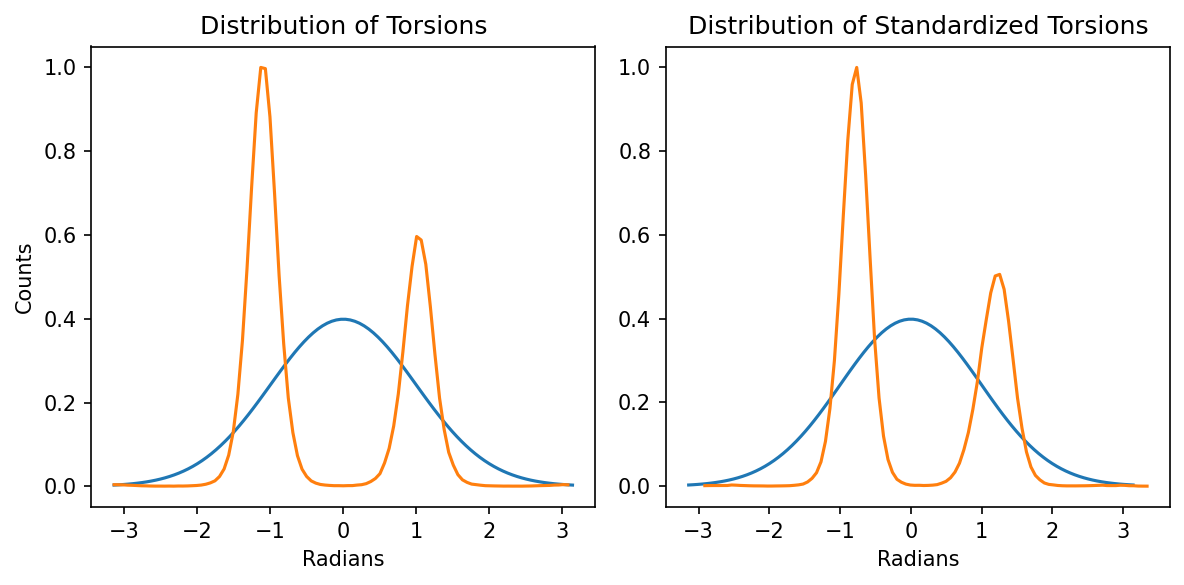

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=150, tight_layout=True);
x = np.linspace(-np.pi,np.pi,100)
counts, xe = np.histogram(loader.data.ravel()[::10], bins=100)
prob = counts/counts.max()
counts_std, xe_std = np.histogram(loader.data_std.ravel()[::10], bins=100)
prob_std = counts_std/counts_std.max()

pdf = stats.norm.pdf(x, 0, 1)
axs[0].plot(x, pdf)
axs[0].plot(xe[:-1], prob);
axs[1].plot(x, pdf)
axs[1].plot(xe_std[:-1], prob_std);

axs[0].set_xlabel("Radians")
axs[0].set_ylabel("Counts")
axs[0].set_title("Distribution of Torsions")
axs[1].set_xlabel("Radians")
axs[1].set_title("Distribution of Standardized Torsions")

The __Backbone__ class is simply a wrapper around the architecture used to predict the score. It automatically initializes optimizers and learning rate schedulers, and has methods to save and load models from files. It also handles upsampling and downsampling of data to be compatible with the model.

In [ ]:
backbone = ConvBackbone1D(model=model, # model
                          data_shape=num_torsions, # data shape
                          target_shape=model_dim, # network shape
                          num_dims=len(loader.data_std.shape),
                          lr=1e-4
                         )

The __VPDiffusion__ class implements the diffusion process in [__Score-Based Generative Modeling through Stochastic Differential Equations__](https://openreview.net/pdf/ef0eadbe07115b0853e964f17aa09d811cd490f1.pdf). In the paper, the authors derive three SDEs with gaussian stationary distributions: the Variance Exploding (VE) SDE, the Variance Preserving (VP) SDE, and the sub-Variance preserving (sub-VP) SDE. 

Each SDE differs in their choice of drift and and noise coefficients.

The VP-SDE has the form

$$
\mathrm{d}\mathbf{x} = -\frac{1}{2}\beta(t) \mathbf{x}\mathrm{d}t + \sqrt{\beta(t)}d\mathbf{w}.
$$

where $\beta(t)$ is a monotonically increasing function of $t$. Since the drift coefficient $f(x,t) = \frac{1}{2}\beta(t)\mathbf{x}$ is linear in $\mathbf{x}$, the transition kernels have a simple closed-form solutions:


$$
\mathcal{N}\left(\mathbf{x}_t | \mathbf{x}_0\right) = \mathcal{N}\left(e^{-\frac{1}{2}\int_0^t \beta(s)ds}\mathbf{x}_0 \; \Big|\;(1-e^{-\frac{1}{2}\int_0^t \beta(s)ds}) \mathbf{I}\right).
$$

It is often easier to work with $\alpha_t = e^{-\frac{1}{2}\int_0^t \beta(s)ds}$ directly rather than $\beta(t)$, which is the approach we will take here. We use the polynomial noise parameterization in Hoogeboom et. al.

The __VPDiffusion__ class has methods which apply the transition kernels $p(x_t|x_0)$, $q(x_0|x_t)$, and $p(x_{t+1}|x_t)$ to the data. These transition kernels characterize the discrete-time forward ($p$) and reverse ($q$) SDEs. This is the Markov chain formulation originally given in [__Deep Unsupervised Learning using Nonequilibrium Thermodynamics__](http://proceedings.mlr.press/v37/sohl-dickstein15.pdf), [__Denoising Diffusion Probabilistic Models__](https://proceedings.neurips.cc/paper_files/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf), and [__Denoising Diffusion Implicit Models__](https://proceedings.neurips.cc/paper_files/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf).


The discrete (or continuous) time forward SDE can be evaluated in a single step as
$$
\mathbf{x}_t = \sqrt{\alpha_{t}}\mathbf{x}_0 + \sqrt{1-\alpha_t}\epsilon
$$
since the above kernel has closed form. Note that the original sample can be reconstructed given $\mathbf{x}_t$ and $\epsilon$ by solving for $\mathbf{x}_0$ (this reconstruction is typically denoted as $\mathbf{\hat{x}}^0_t$, and is important for inference when the true $\mathbf{x}_0$ does not exist or is unknown.

Less straightforwardly, the reverse SDE can be discretized as
$$
\mathbf{x}_{t+1} = \sqrt{\alpha_{t-1}} \left( \frac{\mathbf{x}_t - \sqrt{1-\alpha_t}\mathbf{\epsilon}_\theta^{(t)}(\mathbf{x}_t)}{\sqrt{\alpha_t}} \right) + \sqrt{1 − \alpha_{t-1} - \sigma_t^2}\epsilon_\theta^{(t)}(\mathbf{x}_t) + \sigma_t \epsilon_t,
$$ 
where $\epsilon_t$ is isotropic gaussian noise, and the first term inside the parentheses is $\mathbf{\hat{x}}_0^{(t)}$ &ndash; the network's prediction of $\mathbf{x}_0$ conditional on the information present at timestep $t$. The second term points back towards the noisy sample $\mathbf{x}_t$, so that the process of moving towards $\mathbf{x}_0$ is gradual. The term $\sigma_t$ can be chosen freeley. A choice of $\sigma_t = \sqrt{(1-\alpha_{t-1})/({1-\alpha_t})}\sqrt{1-\alpha_t/\alpha_{t-1}}$ corresponds to the original DDPM implementation, while choosing $\sigma_t = 0$ makes the generative process deterministic, turning the reverse-diffusion SDE into an ODE. 

The discretization is first derived in [__Denoising Diffusion Implicit Models__](https://openreview.net/pdf?id=St1giarCHLP), as can be represented graphically as 
![DDIM](https://github.com/lherron2/simple-diffusion/blob/main/img/DDIM.png?raw=1)

The implementation of __VPDiffusion__ uses this update equation with $\sigma_t=0$ to transform noise into data.






In [ ]:
diffusion = VPDiffusion(num_diffusion_timesteps=100)

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


Diffusion models can be trained with variational or score-matching objectives. In fact, the two loss functions only differ by a multiplicative factor relating to the parameterization of the noise schedule. The score-matching loss and simpler and more widely used in the community, so we will use it here. The score-matching loss is 
$$
\mathcal{L} =\sum\nolimits_{\mathbb{E}(\mathbf{x}_0 \sim p(\mathbf{x}_0), \epsilon \sim \mathcal{N}(0, \mathbf{I}))} \lvert \lvert \epsilon_\theta^{(t)}(\mathbf{x}_t) - \epsilon \rvert \rvert^2.
$$
And $\epsilon_\theta^{(t)}(\mathbf{x}_t, \alpha_t)$ is the prediction of the noise which was added to the original sample $\mathbf{x}_0$ to produce $\mathbf{x}_t$


Oftentimes the network is trained on the score-matching loss, and the variational loss (see [__Variational Diffusion Models__](https://openreview.net/pdf?id=2LdBqxc1Yv)) is evaluated during sampling as one method to find log-probabilities. So, training a diffusion model is simple. First randomly choose a sample $\mathbf{x}_0$ and add randomly sampled noise $\epsilon \sim \mathcal{N}(0, \mathbf{I})$. Then compute $\mathbf{x}_t$ using $\mathbf{x}_0$, $\epsilon$, and the noise schedule $\alpha_t$. Finally, train a neural network to estimate $\epsilon$ given $\mathbf{x}_t$ using the objective above.  


In [ ]:
def train_loop(train_loader, backbone, diffusion, num_epochs=50):
    
    def l2_loss(x, x_pred):
        return (x - x_pred).pow(2).sum((1,2)).pow(0.5).mean()
    
    for epoch in range(num_epochs):
        for i, b in enumerate(train_loader, 0):

            # sample set of times
            t = torch.randint(low=0, 
                          high=diffusion.num_diffusion_timesteps, 
                          size=(b.size(0),)).long()

            # corrupt data according to noise schedule
            b_t, e_0 = diffusion.forward_kernel(b, t)

            # predict noise and original data
            b_0, e_t = diffusion.reverse_kernel(b_t, t, backbone, "x0")

            # evaluate loss and do backprop
            loss = l2_loss(b_t, b_0)
            backbone.optim.zero_grad()
            loss.backward()
            backbone.optim.step()

            if i % 100 == 0:
                print(f"step: {i}, loss {loss.detach():.3f}")
        backbone.save_state(directory, epoch)

In [ ]:
train_loader = torch.utils.data.DataLoader(loader, batch_size=512, shuffle=True)

# training the diffusion model
train_loop(train_loader, backbone, diffusion)

step: 0, loss 4.168
step: 100, loss 0.514
step: 200, loss 0.183
step: 300, loss 0.120
step: 400, loss 0.088
step: 500, loss 0.068
step: 600, loss 0.060
step: 700, loss 0.053
step: 800, loss 0.052
step: 900, loss 0.044
step: 0, loss 0.043
step: 100, loss 0.042
step: 200, loss 0.036
step: 300, loss 0.036
step: 400, loss 0.027
step: 500, loss 0.029
step: 600, loss 0.029
step: 700, loss 0.025
step: 800, loss 0.028
step: 900, loss 0.027
step: 0, loss 0.022
step: 100, loss 0.028
step: 200, loss 0.041
step: 300, loss 0.039
step: 400, loss 0.030


KeyboardInterrupt: ignored

<font size="3">Sampling amounts to generating random noise and iteratively solving the update equation above using the trained network.</font>

In [ ]:
def sample_batch(batch_size, loader, diffusion, backbone, pred_type="x0"):
    
    def sample_prior(batch_size, shape):
        "Generates samples of gaussian noise"
        prior_sample =  torch.randn(batch_size, *shape[1:], dtype=torch.float)
        return prior_sample

    def get_adjacent_times(times):
        """
        Pairs t with t+1 for all times in the time-discretization
        of the diffusion process.
        """
        times_next = torch.cat((torch.Tensor([0]).long(), times[:-1]))
        return list(zip(reversed(times), reversed(times_next)))

    xt = sample_prior(batch_size, loader.data_std.shape)
    time_pairs = get_adjacent_times(diffusion.times)

    for t, t_next in time_pairs:
        print(int(t))
        t = torch.Tensor.repeat(t, batch_size)
        t_next = torch.Tensor.repeat(t_next, batch_size)
        xt_next = diffusion.reverse_step(xt, t, t_next, backbone, pred_type=pred_type)
        xt = xt_next
    return xt

def save_batch(batch, save_prefix, save_idx):
    os.makedirs(directory.sample_path, exist_ok=True)
    file = os.path.join(directory.sample_path, f"{save_prefix}_idx={save_idx}.npz")
    np.savez_compressed(file, data=batch)

def sample_loop(num_samples, batch_size, save_prefix, loader, diffusion, backbone):
    
    # computing number of runs required to produce num_samples with batch_size constraint
    n_runs = max(num_samples//batch_size, 1)
    if num_samples <= batch_size:
        batch_size = num_samples
        
    # iteratively sampling and saving
    with torch.no_grad():
        for save_idx in range(n_runs):
            x0 = sample_batch(batch_size, loader, diffusion, backbone)
            print(x0.shape)
            x0_unstd = loader.transform.unstandardize(x0.squeeze())
            save_batch(x0_unstd, save_prefix, save_idx)

In [ ]:
backbone.load_model(directory, 0) # load model from epoch
sample_loop(5000, 1000, "aib9", loader, diffusion, backbone)

99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
torch.Size([1000, 1, 18])
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
torch.Size([1000, 1, 18])
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def FE_hist(data, phi_idx, psi_idx, bw=0.1, bins=None):
    
    if bins is None:
        bins = [np.arange(min(data[:,phi_idx]), max(data[:,phi_idx]) + bw, bw), 
                    np.arange(min(data[:,psi_idx]), max(data[:,psi_idx]) + bw, bw)]        

    counts, xedges, yedges = np.histogram2d(data[:,phi_idx], data[:,psi_idx], 
                                           bins=bins, density=True)
    prob = counts
    G = -np.log(prob)
    G[G == np.inf] = -1
    G[G == -1] = max(G.ravel())
    G -= min(G.ravel())
    return G, xedges, yedges

<ipython-input-20-ae73a329e368>:13: RuntimeWarning: divide by zero encountered in log
  G = -np.log(prob)


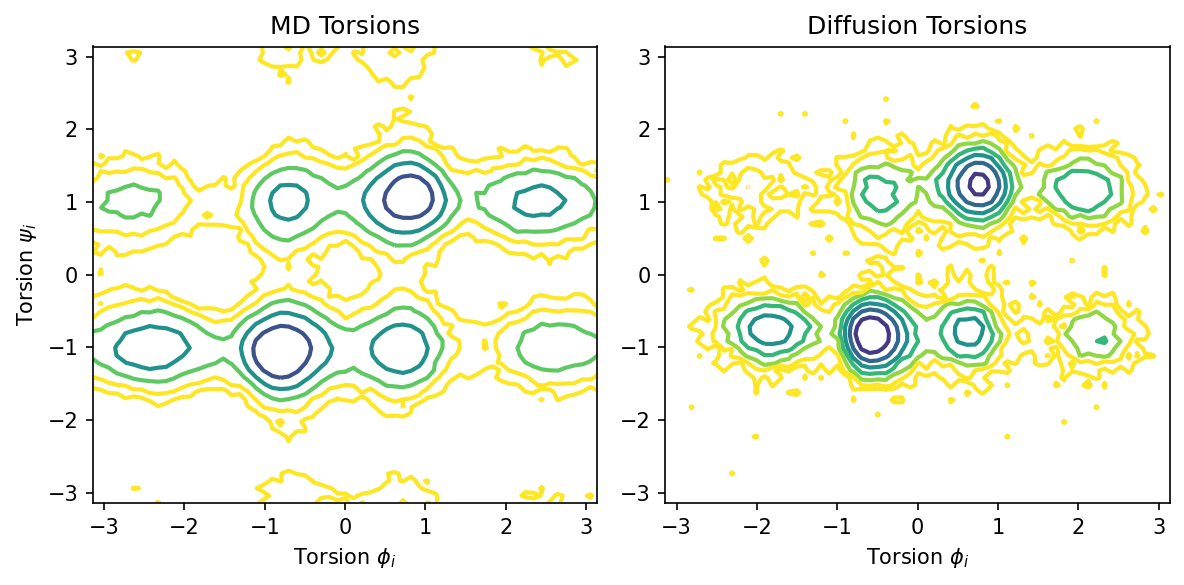

In [ ]:
# 2D FES of MD data
phi_idx = 1
psi_idx = 2
MD_data = loader.data.numpy().squeeze()
G_MD, xe_MD, ye_MD = FE_hist(MD_data, 
                             phi_idx,
                             psi_idx,
                             bw=0.1)

# 2D FES of diffusion data
DDPM_data = np.concatenate([np.load(f.path)['data'].squeeze() 
                            for f in os.scandir(directory.sample_path) if f.is_file()])
G_DDPM, xe_DDPM, ye_DDPM = FE_hist(DDPM_data, 
                                   phi_idx,
                                   psi_idx,
                                   bw=0.1)

fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=150, tight_layout=True);
axs[0].contour(G_MD.T, extent=[xe_MD[0], xe_MD[-1], ye_MD[0], ye_MD[-1]],
        linewidths=2, vmin=0, vmax=6)
axs[1].contour(G_DDPM.T, extent=[xe_DDPM[0], xe_DDPM[-1], ye_DDPM[0], ye_DDPM[-1]],
        linewidths=2, vmin=0, vmax=6)
axs[0].set_xlabel("Torsion $\phi_i$")
axs[0].set_ylabel("Torsion $\psi_i$")
axs[0].set_title("MD Torsions")
axs[1].set_xlabel("Torsion $\phi_i$")
axs[1].set_title("Diffusion Torsions")
axs[0].set_xlim(-np.pi, np.pi);
axs[0].set_ylim(-np.pi, np.pi);
axs[1].set_xlim(-np.pi, np.pi);
axs[1].set_ylim(-np.pi, np.pi);

Normalizing flows are another method of generative modelling that has become widely used due to their ability to compute exact likelihoods for generated samples. Diffusion models are also capable of likelihood computation, which is exact in the sense that the likelihood estimator is unbiased. 

Estimating the likelihood for samples generated by a diffusion model amounts to keeping track of the divergence of the _deterministic_ probability flow ODE in the neighborhood of the sample. More precisely, the likelihood of a sample $\mathbf{x}_0$ generated from noise $\mathbf{x}_T$ is

$$
\log p(\mathbf{x}_0) = \log p(\mathbf{x}_T) + \int_0^T \nabla \cdot \tilde{\mathbf{f}}_\theta(\mathbf{x}_t, t) \mathrm{d}t,
$$

where $\tilde{\mathbf{f}}_\theta(\mathbf{x}_t, t)$ is the reverse flow

$$
\begin{align}
\frac{\mathrm{d}\mathbf{x}_t}{\mathrm{d}t} =& \;\tilde{\mathbf{f}}_\theta(\mathbf{x}_t, t) \\
=& \; \mathbf{f}(\mathbf{x}_t,t) - \frac{1}{2}\nabla \cdot g(t)^2 - \frac{1}{2} g(t)^2 \mathbf{s}_\theta(\mathbf{x}_t, t)
\end{align}.
$$

Evaluating the divergence of $\tilde{\mathbf{f}}_\theta(\mathbf{x}_t, t)$ exactly is costly in most cases, so one can use the Skilling-Hutchinson trace estimator to approximate  
$$
\nabla \cdot \tilde{\mathbf{f}}_\theta(\mathbf{x}_t, t) = \mathbb{E}_{p(\mathbf{\epsilon})}\left[ \mathbf{\epsilon}^\mathrm{T} \nabla \tilde{\mathbf{f}}_\theta(\mathbf{x}_t, t) \mathbf{\epsilon} \right],
$$
where $\mathbf{\epsilon} \sim \mathcal{N}(0, \mathbf{I})$. Estimating likelihoods using this method approximately doubles the cost of generating samples. Not bad! A more complete discussion of likelihood computation may be found in Appendix D of [__Score-Based Generative Modeling through Stochastic Differential Equations__](https://openreview.net/pdf/ef0eadbe07115b0853e964f17aa09d811cd490f1.pdf).

An implementation of likelihood computation is still a WIP for this notebook.